In [1]:
from tools.siren import *
from tools.table import *

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator

import jax
import jax.numpy as jnp
import time

from jax import jit

In [2]:
default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
#Nphot = 1_000_000
Nphot = 10000
temperature = 500.0

In [3]:
simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature)

In [4]:
# Generate and save a single event
key = jax.random.PRNGKey(15000)

# cone on the wall
true_params = (
    jnp.array(30.0),  # opening angle
    jnp.array([0.0, 2.0, 0.0]),  # positionn
    jnp.array([0.0, -1.0, 0.0]),  # direction
    jnp.array(1.0)  # intensity
)

single_event_data = simulate_event(true_params, key)

save_single_event(single_event_data, true_params, filename='events/test_event_data.h5')

'events/test_event_data.h5'

Event Parameters:
────────────────────
Opening Angle: 30.00 degrees
Initial Position: (0.00, 2.00, 0.00)
Initial Direction: (0.00, -1.00, 0.00)
Initial Intensity: 1.00
────────────────────


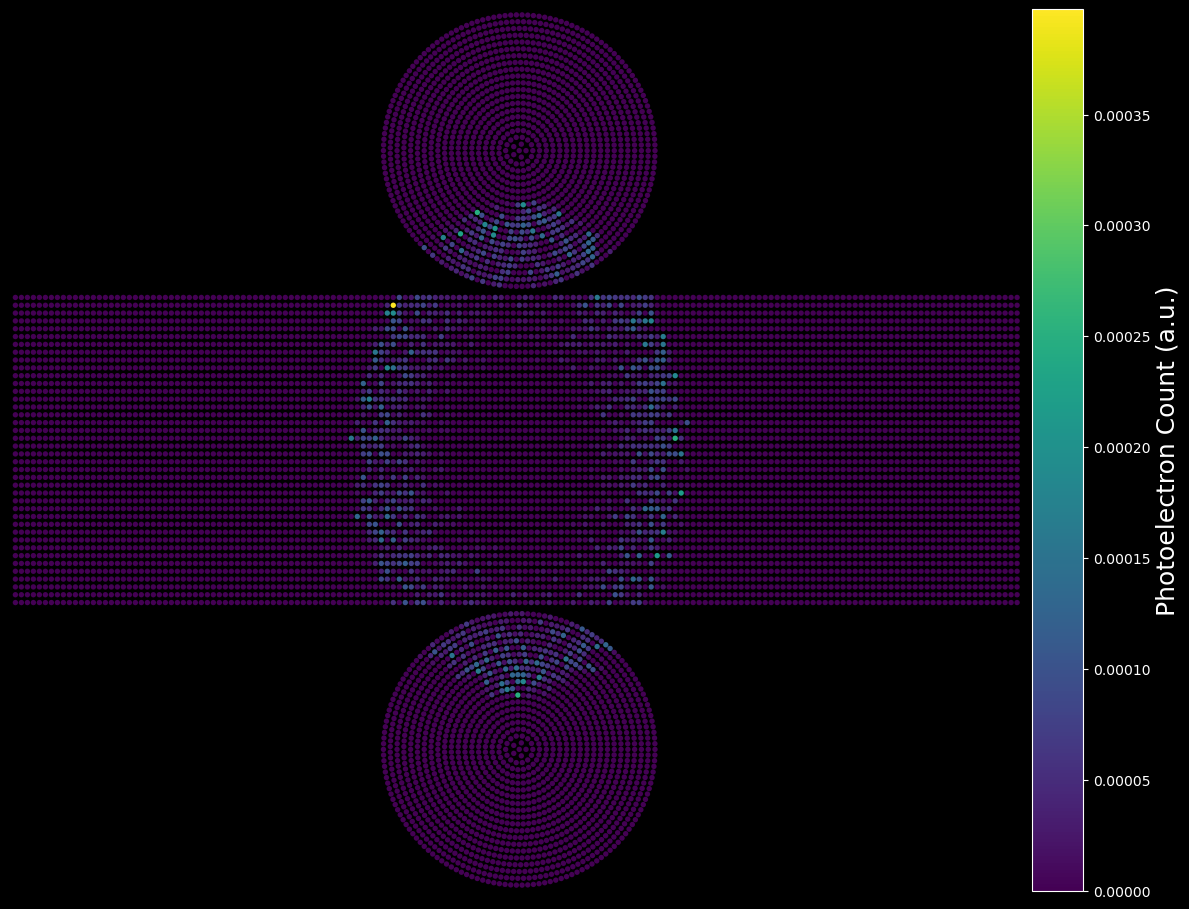

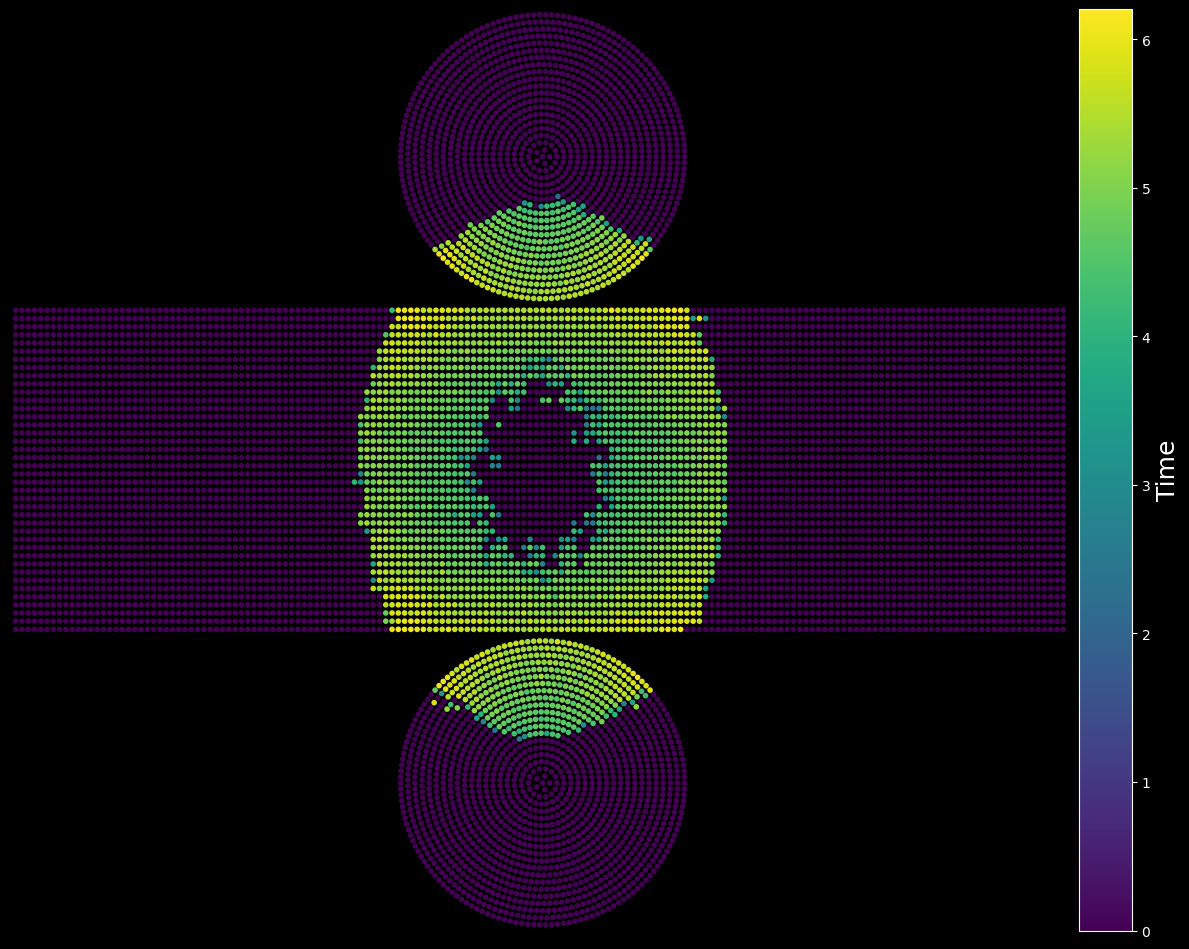

In [5]:
from tools.visualization import create_detector_display
event_location = 'events/test_event_data.h5'
loaded_params, loaded_indices, loaded_charges, loaded_times = load_single_event(event_location, NUM_DETECTORS)
print_params(loaded_params)

detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=True)

0
20
40
60
80
100
120
[ -5.313757    -6.839411    -6.389244     1.2439436   -4.7246904
  -0.5923861   -4.785043    -0.14578187   1.9835283  -10.77272
 -22.111866    -9.507472    -7.2302094   -0.7544725   -9.516075
  -0.22724354 -17.931444    -9.735889   -13.850905    -5.302033
  -2.947674   -16.789042   -10.574703    -6.7757664  -11.050697
  -6.096592   -19.067749   -19.125273   -15.203818    -6.1677127
  -7.966326   -12.078533   -13.714856    -3.3510423  -12.652669
 -14.184179   -12.792787   -16.517788   -12.512934   -15.286519
 -23.5384     -13.698003    -8.856398   -10.048446    -7.6499844
 -16.573788    -7.4727793   -7.282997   -15.482622   -21.947115
 -16.903025    -9.73609     -8.516127    -8.5538225   -8.181111
 -20.08483    -20.159498   -16.499908   -41.228325   -41.392147
  34.168343    39.38944     37.83934     21.499168    11.905275
  21.780384     9.175009    15.716386    11.65517     17.88717
   4.509609    -0.60675263  10.327086     7.195266    18.255304
  18.34739      9

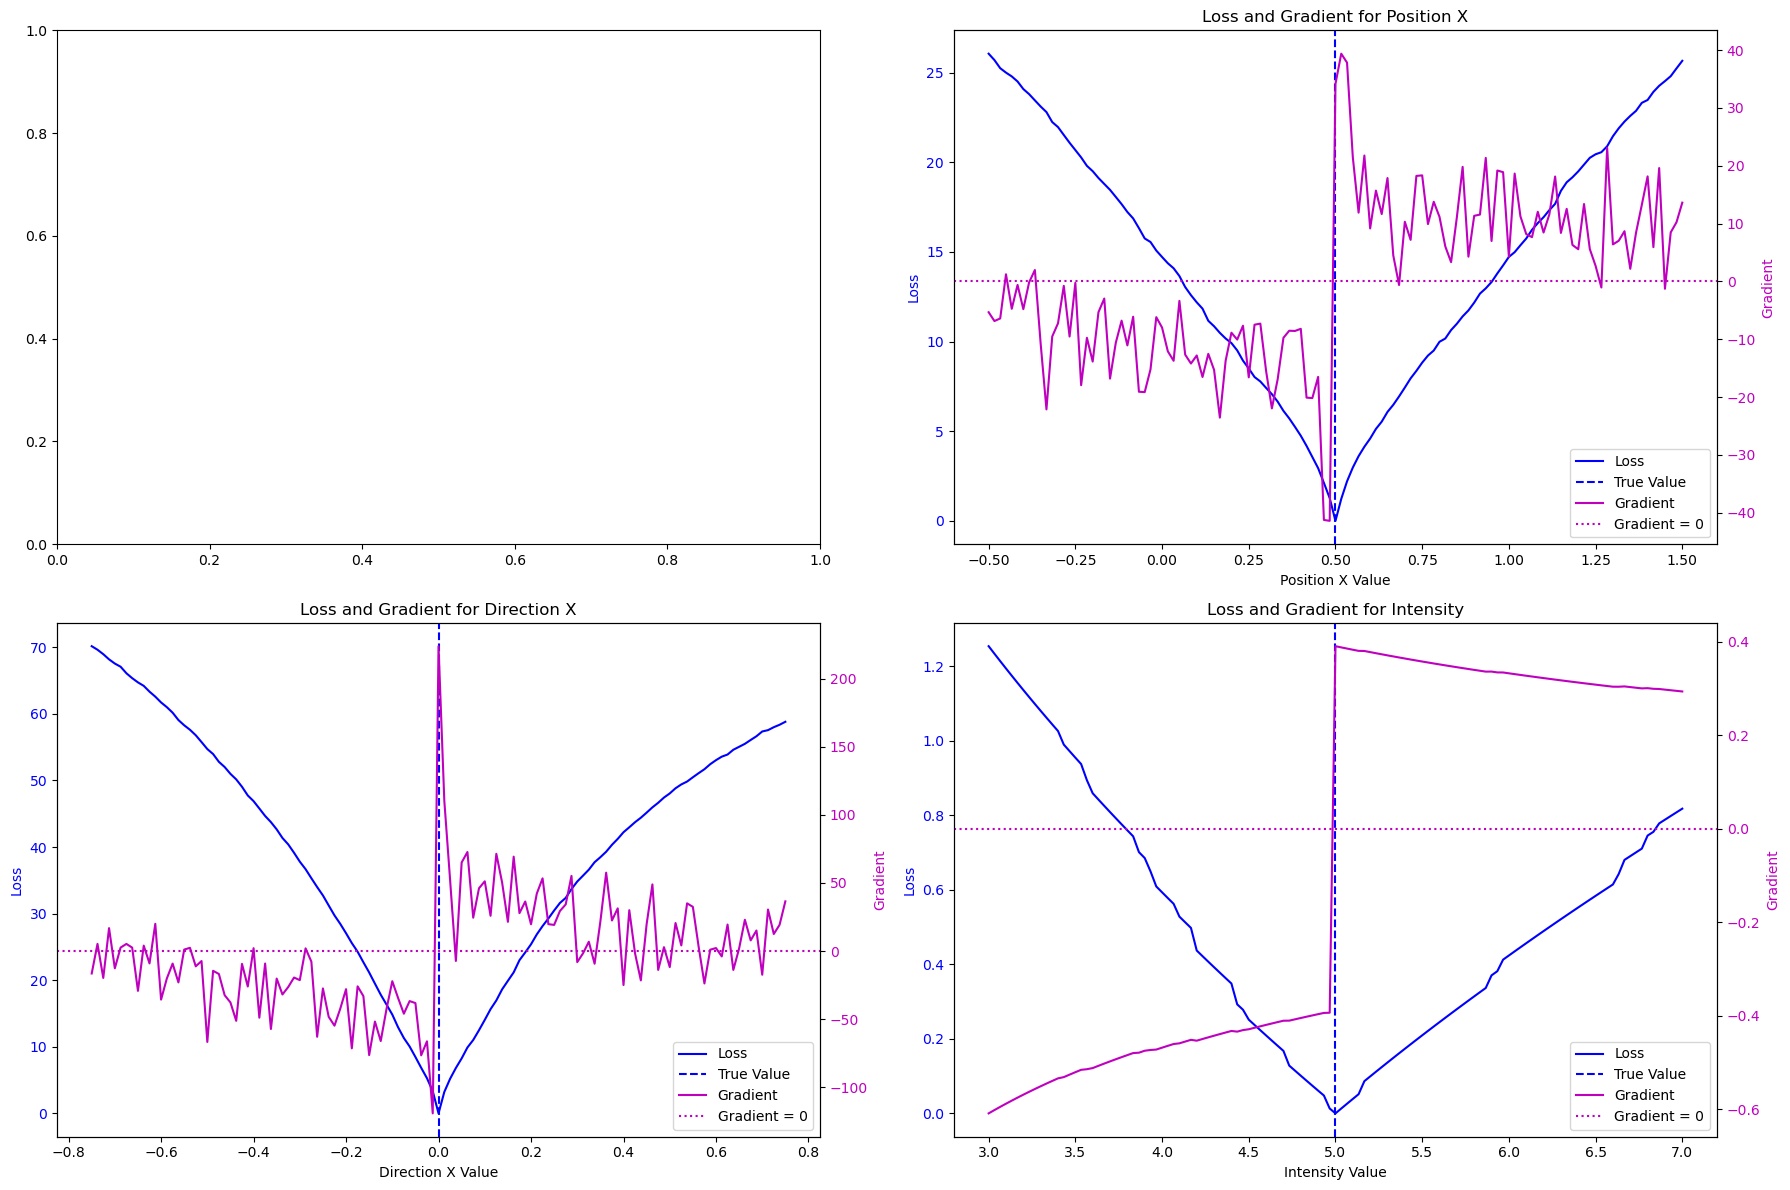

In [6]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.5, 0.0, 1.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# Parameter changes
param_changes = (
    jnp.array(10.0),  # opening angle
    jnp.array([1.0, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.75, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

# Generate true data (without gradients)
key = jax.random.PRNGKey(0)

true_data_temp = jax.lax.stop_gradient(simulate_event(true_params, key))

# save data
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')

# load data, first element is true_params
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss(*true_data, *simulated_data)
    return value_and_grad(loss_fn)(params)

def generate_plot_data(param_index, param_values):
    losses = []
    gradients = []

    cnt = 0
    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
        new_params = tuple(new_params)

        loss, grad = loss_and_grad(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        if cnt%20==0:
            print(cnt)
        cnt+=1
        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 121
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

for i, (row, col) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    if i > 0:
        param_values = param_ranges[i]
        losses, gradients = generate_plot_data(i, param_values)
    
        print(gradients)
        
        ax1 = axs[row, col]
        ax2 = ax1.twinx()
        
        ax1.plot(param_values, losses, 'b-', label='Loss')
        ax2.plot(param_values, gradients, 'm-', label='Gradient')
        
        # Add vertical line at the center (true parameter value)
        true_value = true_params[i] if i not in [1, 2] else true_params[i][0]
        ax1.axvline(x=true_value, color='b', linestyle='--', label='True Value')
        
        # Add horizontal line for gradient at zero
        ax2.axhline(y=0, color='m', linestyle=':', label='Gradient = 0')
        
        ax1.set_xlabel(f'{param_names[i]} Value')
        ax1.set_ylabel('Loss', color='b')
        ax2.set_ylabel('Gradient', color='m')
        
        ax1.tick_params(axis='y', labelcolor='b')
        ax2.tick_params(axis='y', labelcolor='m')
        
        ax1.set_title(f'Loss and Gradient for {param_names[i]}')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()

In [7]:
from jax.experimental import maps
with maps.Profiler("profiler.json"):
    result = new_differentiable_get_rays(...)

ImportError: cannot import name 'maps' from 'jax.experimental' (/Users/cjesus/miniconda3/envs/CIDER/lib/python3.10/site-packages/jax/experimental/__init__.py)